# 策略梯度算法

本次作业包含2个代码填空和3个Exercise。

# 简介
之前我们介绍的Q-learning和DQN及改进算法都是基于价值（value-based）的方法，其中Q-learning是处理有限状态的算法，而DQN可以用来解决连续状态的问题。在强化学习中，除了基于值函数的方法，还有一支非常经典的方法，那就是基于策略（policy-based）的方法。对比两者，基于值函数的方法主要是学习值函数，然后根据值函数导出一个策略，此时并不存在一个显式的策略；而基于策略的方法则是直接显式的学习一个目标策略。策略梯度是基于策略的方法的基础，我们将从策略梯度算法说起。
# 策略梯度
基于策略的方法首先需要参数化策略，我们假设目标策略$\pi_\theta$是一个随机性策略，并且处处可微，其中$\theta$是对应的参数。我们的目标是要寻找一个最优策略，来最大化这个策略在环境中的期望回报。我们将策略学习的目标函数定义为
$$
J(\theta)= \mathbb{E}_{s_0}\left[V^{\pi_\theta}(s_0)\right]
$$
其中$s_0$表示初始状态。现在有了目标函数，我们将目标函数对策略$\theta$求导，得到导数后，我们就可以用梯度上升方法来最大化这个目标函数从而得到最优策略。

我们之前在MDP章节中学习过在策略$\pi$下的状态访问分布，我们在此用$\nu^{\pi}$表示。然后我们对目标函数求梯度，可以得到如下式子，更详细的推导将在扩展阅读中给出。

$$
\begin{align}
\nabla_{\theta}J(\theta)
&\propto \sum_{s \in S}\nu^{\pi_{\theta}}(s)\sum_{a \in A}Q^{\pi_{\theta}}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)\\
&=\sum_{s \in S}\nu^{\pi_{\theta}}(s)\sum_{a \in A}\pi_{\theta}(a|s)Q^{\pi_{\theta}}(s,a)\frac{\nabla_{\theta}\pi_{\theta}(a|s)}{\pi_{\theta}(a|s)}\\
&= \mathbb{E}_{\pi_{\theta}}[Q^{\pi_{\theta}}(s,a)\nabla_{\theta}\log \pi_{\theta}(a|s)]
\end{align}
$$
于是，我们就可以用这个梯度来更新策略。需要注意的是，因为上式期望$\mathbb{E}$的下标是$\pi_{\theta}$，所以策略梯度算法为在线策略（on-policy）算法，即必须使用当前策略$\pi_\theta$采样得到的数据来计算梯度。更一般地，我们可以把梯度写成下面这个形式：
$$
g = \mathbb{E}_{\pi_{\theta}}[\sum^{\infty}_{t=0}\psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})]
$$
其中$\psi_{t}$可以有很多种形式：
$$
\begin{align}
&1.\psi_{t}=\sum_{t=0}^{\infty}\gamma^t r_{t} : 轨迹的总回报  &&4.Q^{\pi_{\theta}}(s_{t},a_{t}) : 动作价值函数\\
&2.\psi_{t}=\sum_{t'=t}^{\infty} \gamma^{t'-t} r_{t'} : 动作 a_{t}之后的回报 &&5.A^{\pi_{\theta}}(s_{t},a_{t}): 优势函数\\
&3.\psi_{t}=\sum_{t'=t}^{\infty}r_{t'}-b(s_{t}) : 基准线版本的改进 \quad\quad \quad\quad &&6.r_{t} + V^{\pi_{\theta}}(s_{t+1}) - V^{\pi_{\theta}}(s_t) : 时序差分残差
\end{align}
$$
在计算策略梯度的公式中，我们需要用到$Q^{\pi_{\theta}}(s,a)$，可以用多种方式对它进行估计。接下来要介绍的 REINFORCE 算法便是采用了蒙特卡洛方法来估计$Q^{\pi_{\theta}}(s,a)$。

**Exercise 1.** 请简单阐述策略梯度方法与基于值函数的方法有何区别。

- 基于值函数的方法：
   - 关键在于学习拟合值函数 $V(s)$ 和 $Q(s,a)$
   - 在拟合价值函数之后根据贪婪策略选择当前方法来最大化收益：$a^* = \arg \max_{a \in A} Q(s,a)$
   - 值函数往往在连续的动作空间中难以处理
- 策略梯度方法：
   - 直接学习智能体策略 $\pi_\theta (a|s)$，输出每个状态下采取各个动作的概率分布
   - 策略梯度天然适合处理连续动作空间，可以输出连续动作的概率分布
   - 可能会陷入收敛到局部最优解

# REINFORCE 算法
REINFORCE就是在上文中当$\psi_t=\sum_{t'=t}^{\infty}\gamma^{t'-t}r_{t'}$时的策略梯度算法。
具体流程如下：
$$
\begin{align}
&\cdot 初始化策略参数\theta \\
&\cdot \texttt{for}\quad 序列\quad e=1\to E\quad \texttt{do}: \\
&\cdot\qquad 用当前策略\pi_\theta采样轨迹\{s_{1},a_{1},r_{1},s_{2},a_{2},r_{2} ... s_{t},a_{t},r_{t}\}\\
&\cdot\qquad 计算当前轨迹每个时刻t往后的回报\sum_{t'=t}^{\infty}\gamma^{t'-t}r_{t'}，记为\psi_{t}\\
&\cdot\qquad 对\theta进行更新 \theta = \theta + \alpha \sum_{t=0}^{\infty}\psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})\\
&\cdot\texttt{end for}
\end{align}
$$

In [ ]:
%pip install -i https://mirrors.sjtug.sjtu.edu.cn/pypi/web/simple gym
%pip install torch # No need to install cuda toolkit!

In [3]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.distributions import Categorical

eps = np.finfo(np.float32).eps.item()

定义我们的策略网络PolicyNet，输入是状态state，输出则是采取动作action的概率值（离散动作空间）

In [4]:
class PolicyNet(torch.nn.Module):
    def __init__(self, hidden_dim, state_space, action_space):
        super(PolicyNet, self).__init__()
        input_dim = state_space.shape[0]
        output_dim = action_space.n
        
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return  F.softmax(self.fc2(x), dim=1)

再定义我们的REINFORCE的Agent。在函数action()中，我们通过概率对离散的动作进行采样。在更新Agent的过程中，我们按照算法，将损失函数写为$-\sum_{t}\psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})$，对$\theta$求导就可以更新策略。

In [5]:
class Reinforce:
    def __init__(
        self, 
        hidden_size, state_space, action_space, 
        learning_rate, device, step_size, lr_gamma
    ):
        self.action_space = action_space
        self.model = PolicyNet(hidden_size, state_space, action_space).to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size, lr_gamma)

    def action(self, state):
        ########################################
        ## Programming 1: 计算正确的action以及log_prob
        ########################################
        state_tensor = torch.FloatTensor(state).to(self.device) if not isinstance(state, torch.Tensor) else state
        action_probs = self.model(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        ########################################
        ## End of Programming 1
        ########################################
        return action, log_prob

    def update(self, rewards, log_probs, gamma):
        ########################################
        ## Programming 2: 更新策略网络
        ## REINFORCE算法通常不太稳定，如果得到的结果不理想可以尝试：
        ## 1. 对**Return**做标准化
        ## 2. 使用learning rate调节器
        ########################################
        
        # 计算折扣回报
        R = 0
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        
        # 标准化回报以减少方差
        returns = (returns - returns.mean()) / (returns.std() + eps)
        
        # 计算损失函数
        loss = []
        for log_prob, R in zip(log_probs, returns):
            loss.append(-log_prob * R)
        
        loss = torch.stack(loss).sum()
        
        # 反向传播更新参数
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        
        ########################################
        ## End of Programming 2
        ########################################

定义好策略，我们就可以开始实验了，看看Reinforce在Cartpole环境上表现如何吧！

预计运行时间：2分钟

In [6]:
# 以下参数在助教实现的版本中能达到期望效果，可以多试几组参数
learning_rate = 1e-3
num_episode = 2000
hidden_size = 128
max_timesteps = 2000
env_name = "CartPole-v1"
gamma = 0.98
lr_gamma = 0.9
step_size = 500
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env = gym.make(env_name)
agent = Reinforce(
    hidden_size, 
    env.observation_space, 
    env.action_space, 
    learning_rate, 
    device,
    step_size,
    lr_gamma
)
rewards_log = []
episodes_log = []
for i_episode in range(num_episode):
    state = torch.Tensor(np.array([env.reset()]), device=device)
    log_probs = []
    rewards = []
    for time_step in range(max_timesteps):
        action, log_prob = agent.action(state)
        action = action.cpu()
        next_state, reward, terminated, truncated = env.step(action.numpy()[0])
        done = terminated or truncated
        log_probs.append(log_prob)
        rewards.append(reward)
        state = torch.Tensor([next_state], device=device)
        if done:
            break
    rewards_log.append(np.sum(rewards))
    episodes_log.append(i_episode)
    agent.update(rewards, log_probs, gamma)
    if (i_episode + 1) % 100 == 0 or i_episode + 1 == num_episode:
        print("Episode: {}, Reward: {}".format(i_episode+1, np.mean(rewards_log[-10:])))
env.close()

/var/folders/2b/h_bq65kn6yl2fnz8tsk_2hvw0000gn/T/ipykernel_99971/469349111.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  state = torch.Tensor([next_state], device=device)


Episode: 100, Reward: 34.6
Episode: 200, Reward: 76.3
Episode: 300, Reward: 184.9
Episode: 400, Reward: 320.2
Episode: 500, Reward: 414.8
Episode: 600, Reward: 427.2
Episode: 700, Reward: 428.6
Episode: 800, Reward: 500.0
Episode: 900, Reward: 444.8
Episode: 1000, Reward: 480.4
Episode: 1100, Reward: 474.3
Episode: 1200, Reward: 480.7
Episode: 1300, Reward: 500.0
Episode: 1400, Reward: 500.0
Episode: 1500, Reward: 489.0
Episode: 1600, Reward: 500.0
Episode: 1700, Reward: 500.0
Episode: 1800, Reward: 490.0
Episode: 1900, Reward: 500.0
Episode: 2000, Reward: 500.0


在CartPole-v1环境中，满分就是500分，让我们来看看每个Episode得分如何吧！

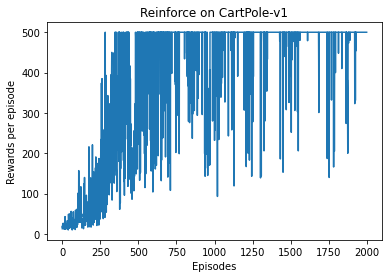

In [7]:
plt.plot(episodes_log,rewards_log)
plt.xlabel('Episodes')   
plt.ylabel('Rewards per episode')  
plt.title('Reinforce on {}'.format(env_name))  
plt.show()

参考训练曲线如下（最后能比较稳定保持在500即可）：

![Image Name](images/result.png)


**Exercise 2.** 在填写代码并训练的过程，你认为REINFORCE算法存在哪些问题？

- 高方差问题：REINFORCE使用蒙特卡洛方法估计回报，单次轨迹的采样方差很大，相同的状态-动作对在不同轨迹中可能得到完全不同的回报估计、高方差导致训练不稳定，收敛速度慢
   - 后续引入优势函数 $A(s,a) = Q(s,a) - V(s)$ 以及 TD Learning 来代替全回合的 Monte Carlo 更新。
   - 上述措施均可以降低累积汇报 $G_t$ 的方差

- 样本效率低下：
   - REINFORCE 算法为 on-policy 算法，需要从环境中实时收集数据进行训练。
   - 后续加入 Importance Sampling (PPO & TRPO) 来保证模型能够利用旧策略的轨迹数据来更新当前的策略
   - 深度离散策略梯度的方法通过离线经验回放池，让历史数据可以被反复训练

- 学习率 $\alpha$ 敏感难以控制：
   - 策略梯度对学习率极其敏感。在 REINFORCE 中，一次权重更新可能导致概率分布发生剧烈跳变。如果某次随机采样运气很差，梯度可能会把策略推向一个“崩溃区”，导致模型后续再也无法探索到有效路径。
   - 后续 TRPO 算法引入 KL 散度的正则约束，强制要求新旧策略的分布差异不能超过一个阈值
   - 后续 PPO 算法引入 CLIP 裁剪机制，限制损失函数的更新幅度。

# 总结
REINFORCE算法理论上是能保证局部最优的。依赖于MC方法进行采样，优点是REINFORCE的采样梯度是无偏的。但是同样由于MC，导致REINFORCE梯度估计的方差很大，从而可能会降低学习的速率，这也是接下来的Actor-Critic算法要解决的问题。

# 拓展阅读：策略梯度证明
我们要证明$\nabla_{\theta}J(\theta) \propto \sum_{s \in S}\nu^{\pi_\theta}(s)\sum_{a \in A}Q^{\pi_\theta}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)$
                        
先从状态价值函数的推导开始：
$$
\begin{align}
\nabla_{\theta}V^{\pi_\theta}(s) &=\nabla_{\theta}(\sum_{a \in A} \pi_{\theta}(a|s)Q^{\pi_\theta}(s,a)) \\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a) + \pi_{\theta}(a|s)\nabla_{\theta}Q^{\pi_\theta}(s,a))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a) + \pi_{\theta}(a|s)\nabla_{\theta}\sum_{s',r}P(s',r|s,a)(r+\gamma V^{\pi_\theta}(s'))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a) + \gamma\pi_{\theta}(a|s)\sum_{s',r}P(s',r|s,a)\nabla_{\theta}V^{\pi_\theta}(s'))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a) + \gamma\pi_{\theta}(a|s)\sum_{s'}P(s'|s,a)\nabla_{\theta}V^{\pi_\theta}(s'))\\
\end{align}
$$
为了简化表示，我们让$\phi(s)=\sum_{a \in A}\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a)$, 定义$\rho^{\pi}(s\rightarrow x, k)$为策略$\pi$从状态s出发k步后到达状态x的概率，我们继续推导:
$$
\begin{align}
\nabla_{\theta}V^{\pi_\theta}(s) &= \phi(s) + \gamma\sum_{a}\pi_{\theta}(a|s)\sum_{s'}P(s'|s,a)\nabla_{\theta}V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma\sum_{a}\sum_{s'}\pi_{\theta}(a|s)P(s'|s,a)\nabla_{\theta}V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma\sum_{s'}\rho^{\pi_\theta}(s \rightarrow s',1)\nabla_{\theta}V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma\sum_{s'}\rho^{\pi_\theta}(s \rightarrow s',1)[\phi(s') + \sum_{s''}\rho^{\pi_\theta}(s' \rightarrow s'',1)\nabla_{\theta}V^{\pi_\theta}(s'')]\\
&= \phi(s) + \gamma\sum_{s'}\rho^{\pi_\theta}(s \rightarrow s',1)\phi(s') + \sum_{s''}\rho^{\pi_\theta}(s \rightarrow s'',2)\nabla_{\theta}V^{\pi_\theta}(s'')\\
&= \phi(s) + \gamma\sum_{s'}\rho^{\pi_\theta}(s \rightarrow s',1)\phi(s') +\gamma^2\sum_{s''}\rho^{\pi_\theta}(s' \rightarrow s'',2)\phi(s'') + \gamma^3\sum_{s'''}\rho^{\pi_\theta}(s \rightarrow s''',3)\nabla_{\theta}V^{\pi_\theta}(s''')\\
&= ......\\
&= \sum_{x \in S}\sum^{\infty}_{k=0}\gamma^k\rho^{\pi_\theta}(s \rightarrow x, k)\phi(x)
\end{align}
$$
OK! 我们定义$\eta(s)= \mathbb{E}_{s_0}\left[\sum^{\infty}_{k=0}\gamma^k\rho^{\pi}(s_{0} \rightarrow s, k)\right]$。
至此我们看回我们的目标函数：
$$
\begin{align}
\nabla_{\theta}J(\theta) &= \nabla_{\theta}\mathbb{E}_{s_0}\left[V^{\pi_\theta}(s_{0})\right]\\
&= \sum_{s}\mathbb{E}_{s_0}\left[\sum^{\infty}_{k=0}\gamma^k\rho^{\pi_\theta}(s_{0} \rightarrow s, k)\right]\phi(s)\\
&= \sum_{s}\eta(s)\phi(s)\\
&= \left(\sum_{s}\eta(s)\right)\sum_{s}\frac{\eta(s)}{\sum_{s}\eta(s)}\phi(s)\\
&\propto \sum_{s}\frac{\eta(s)}{\sum_{s}\eta(s)}\phi(s)\\
&= \sum_{s}\nu^{\pi_\theta}(s)\sum_{a}Q^{\pi_\theta}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)
\end{align}
$$
证明完毕！


**Exercise 3.** 以优势函数$A(s_t,a_t)$为例，请说明为什么沿着梯度$g$的方向优化就可以学到一个收益更大的策略。

**答案：**

优势函数$A(s_t,a_t) = Q(s_t,a_t) - V(s_t)$表示在状态$s_t$下采取动作$a_t$相对于平均水平的优势程度。沿着梯度

$$g = \mathbb{E}_{\pi_{\theta}}[A^{\pi_{\theta}}(s_{t},a_{t})\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})]$$

的方向优化，可以学习到收益更大的策略。

梯度公式可以分解为两个关键部分：
- $A(s_t,a_t)$：衡量动作$a_t$的优劣程度
- $\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})$：指示如何调整参数来增加该动作的概率

- 如果 $A(s_t,a_t) > 0$（考虑做标准化，即代表动作优于平均水平），此时梯度的方向和 $\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})$ 保持相同。沿着梯度的方向更新策略可以保证价值函数处在上升更快的方向，可以学到一个收益更大的策略。具体而言，更新后的 $\theta$ 会增加这个好动作出现的概率。
- 如果 $A(s_t,a_t) < 0$，同理，参数更新会减小此类坏动作的出现概率。

经过多次迭代，策略的概率分布会逐渐向那些高分动作区域收敛，最终学到最优策略。